<style>
    body {
        font-size: 10px;
    }
    .code_cell .input_area {
        font-size: 11px;
    }
    .output_area {
        font-size: 11px;
    }
</style>

---
title: "Evaluating Different Trading Strategies on PFE Stock"
author: "Ivan Hung"
# date: "2025-11-20"
format: pdf
---
\newpage
\tableofcontents
\listoffigures
\listoftables
\newpage

# Load R Packages 

In [355]:
install.packages(c("dplyr", "dtplyr", "data.table", "lubridate", 
"ggplot2", "PerformanceAnalytics", "xts"))


The downloaded binary packages are in
	/var/folders/by/g895l7l128j9y19qqn66xcxh0000gn/T//RtmpW7cOPG/downloaded_packages


In [1]:
#| warning: false
library(dplyr)
library(dtplyr)
library(data.table)
library(lubridate)
library(ggplot2)
library(PerformanceAnalytics)
library(xts)

options(repr.plot.width = 10, repr.plot.height = 4)  # For Jupyter notebooks


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Warning message:
“package ‘ggplot2’ was built under R version 4.5.2”
Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:data.table’:

    yearmon, yearqtr


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ########################

In [357]:
df <- fread("/Users/ivanhung/Documents/GitHub/final-r-assignment/dataset.csv")

# Cleaning dataset 

datadate,cshtrd,prccd,prchd,prcld,prcod
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010-01-04,52074710,18.93,18.94,18.235,18.27
2010-01-05,43368460,18.66,18.93,18.550,18.92
2010-01-06,41405070,18.60,18.81,18.510,18.66
2010-01-07,39427720,18.53,18.67,18.460,18.64
2010-01-08,30403370,18.68,18.71,18.520,18.62
2010-01-11,32442710,18.83,18.95,18.670,18.83


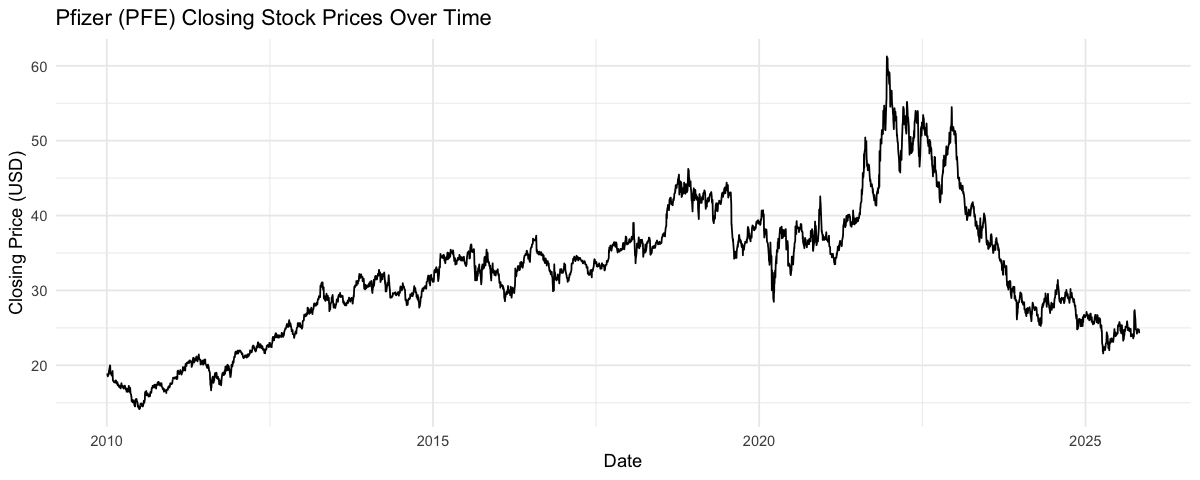

In [358]:
#| fig-cap: "Pfizer Closing Stock Prices Over Time" 
#| tbl-cap: "Cleaned Dataset"
# Setting datadate to a date object
df %>% mutate(datadate = as.Date(datadate, format = "%m/%d/%Y")) -> df

# Remove irrelevant columns and other stocks except for Pfizer (PFE)
pfe <- df[tic == "PFE",
          .(datadate, cshtrd, prccd, prchd, prcld, prcod)]

head(pfe)

# Plot time series of PFE's closing prices 
ggplot(data = pfe, aes(x = datadate, y = prccd)) +
  geom_line() +
  labs(title = "Pfizer (PFE) Closing Stock Prices Over Time",
       x = "Date",
       y = "Closing Price (USD)") +
  theme_minimal()


Next, calculate simple returns so that we can make our prices stationary and allow us to have a better understanding our data as we can proceed to plot Pfizer's ACF and PACF plots and confirm for certain statistical characteristics.

In [359]:
#| tbl-cap: "Simple Returns Table" 
# Calculating simple returns (simple returns in %), 
# which we will denote as s_ret (s_ret_per) 

pfe <- pfe %>%
    mutate(ret = round(((prccd/lag(prccd))-1), 4)) %>%
    mutate(s_ret = round(((prccd/lag(prccd))-1)*100, 4))
    
head(pfe)

datadate,cshtrd,prccd,prchd,prcld,prcod,ret,s_ret
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010-01-04,52074710,18.93,18.94,18.235,18.27,NA,NA
2010-01-05,43368460,18.66,18.93,18.550,18.92,-0.0143,-1.4263
2010-01-06,41405070,18.60,18.81,18.510,18.66,-0.0032,-0.3215
2010-01-07,39427720,18.53,18.67,18.460,18.64,-0.0038,-0.3763
2010-01-08,30403370,18.68,18.71,18.520,18.62,0.0081,0.8095
2010-01-11,32442710,18.83,18.95,18.670,18.83,0.0080,0.8030


Next, we should plot the autocorrelation and partial-autocorrelation functions of our closing prices to identify if there are any seasonal structures or autocorrelation that we might need to deal with.

# ACF and PACF Plot Analysis

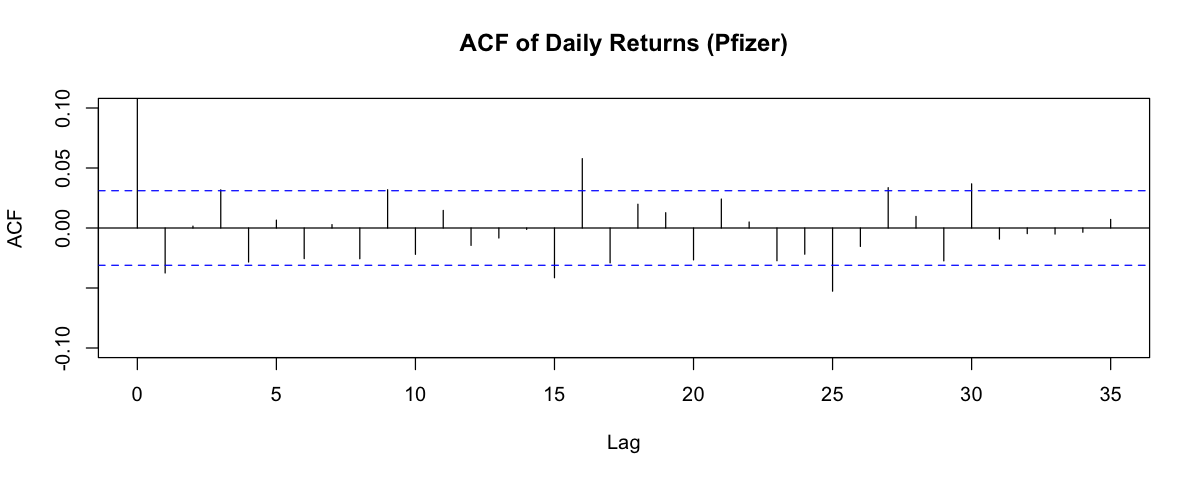

In [360]:
# ACF plot to identify any autocorrelation or seasonality patterns in our data
#| fig-cap: "ACF of Daily Returns Pfizer"
#| warning: false
#| results: hide

acf(pfe$ret, lags = 20, 
    na.action = na.omit, 
    main = "ACF of Daily Returns (Pfizer)",
    ylim = c(-0.1,0.1))

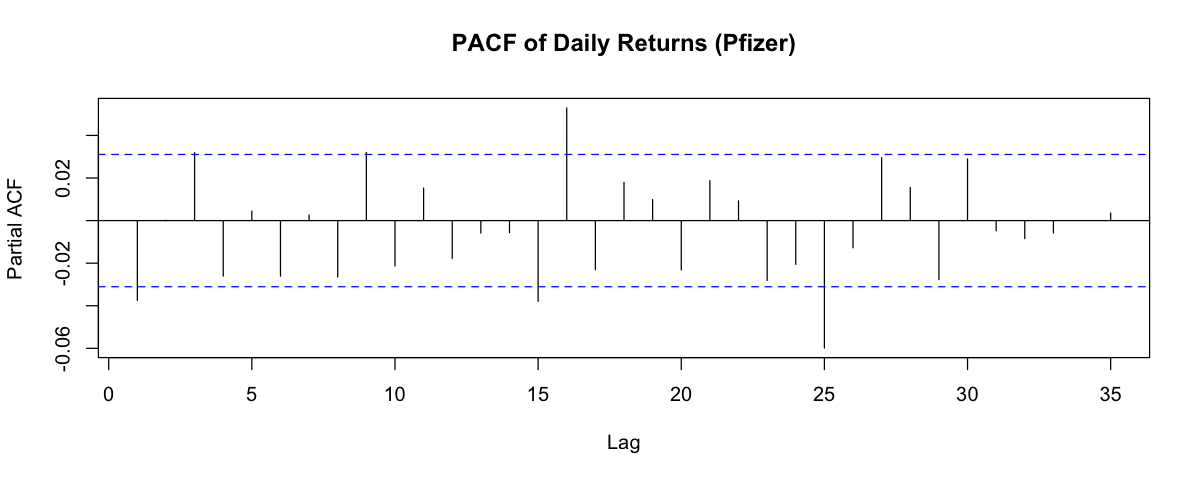

In [361]:
# PACF plot 
#| fig-cap: "PACF of Daily Returns Pfizer"
#| warning: false
#| results: hide

pacf(pfe$ret, lags = 20, 
    na.action = na.omit, 
    main = "PACF of Daily Returns (Pfizer)")

We can focus in on a specific time horizon and see if autocorrelation exists within a certain timeframe. This evidence can help us to determine whether there is statistical arbitrage in which our trading strategy can detect a pattern can profit from (potentially short term momentum), as opposed to having white noise (returns which follow a strong form of the EMH where all information about the stock is reflected in its prices). We decide to focus on a relatively long horizon as it can provide us more information of how the stock's price changed before, during, and after COVID; providing us with a holistic story and finding opportunities for statistical arbitrage in the `3' phases of COVID.

## ACF and PACF - Different Time Horizons

Processing: WEEKLY 


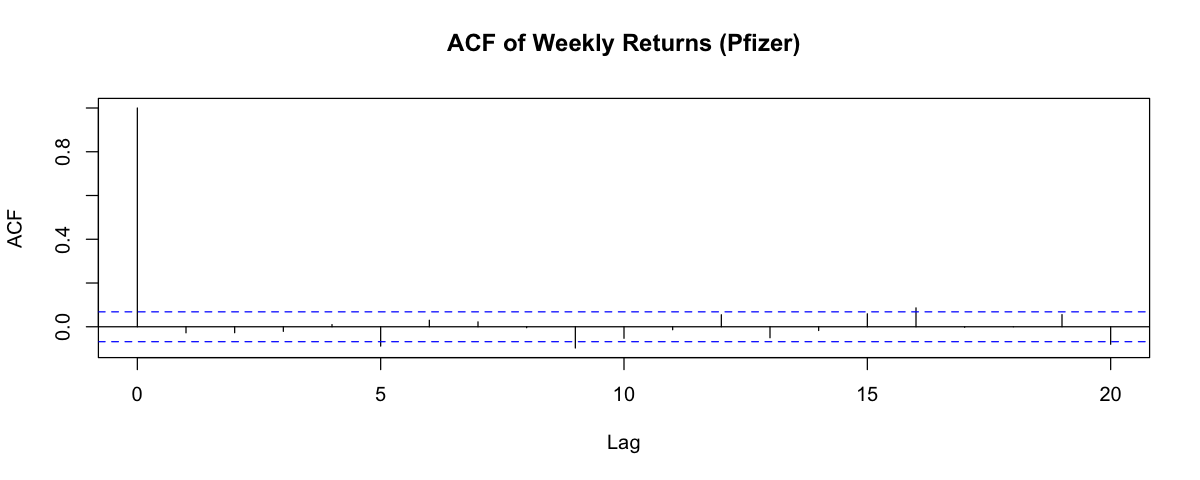

Processing: MONTHLY 


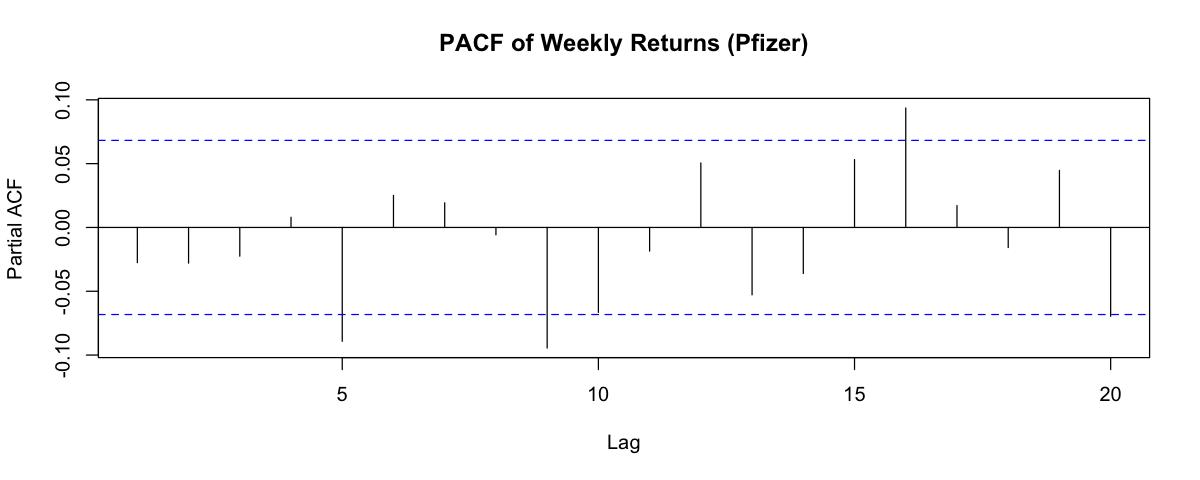

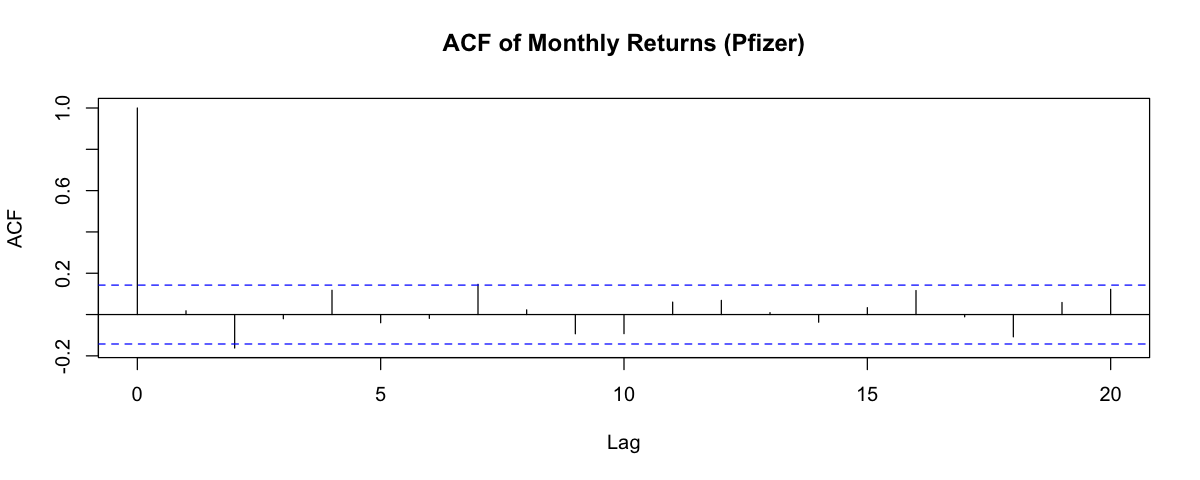

Processing: SEMI_ANNUALLY 


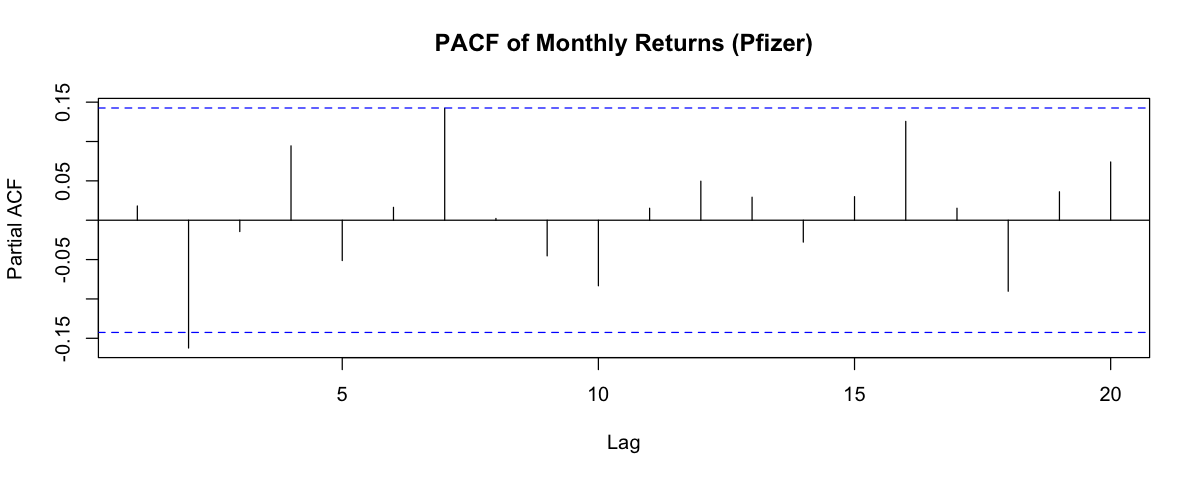

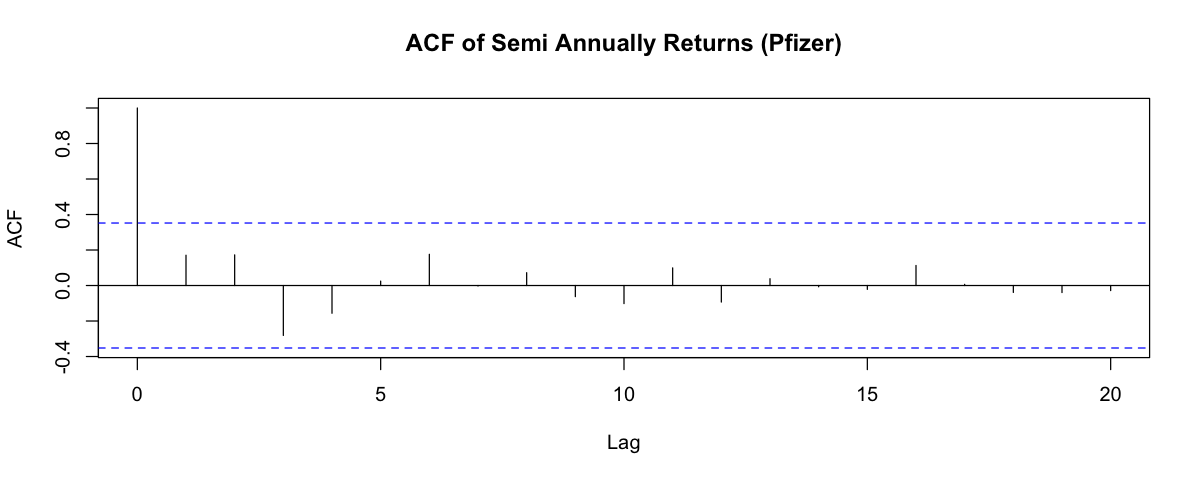

Processing: ANNUALLY 


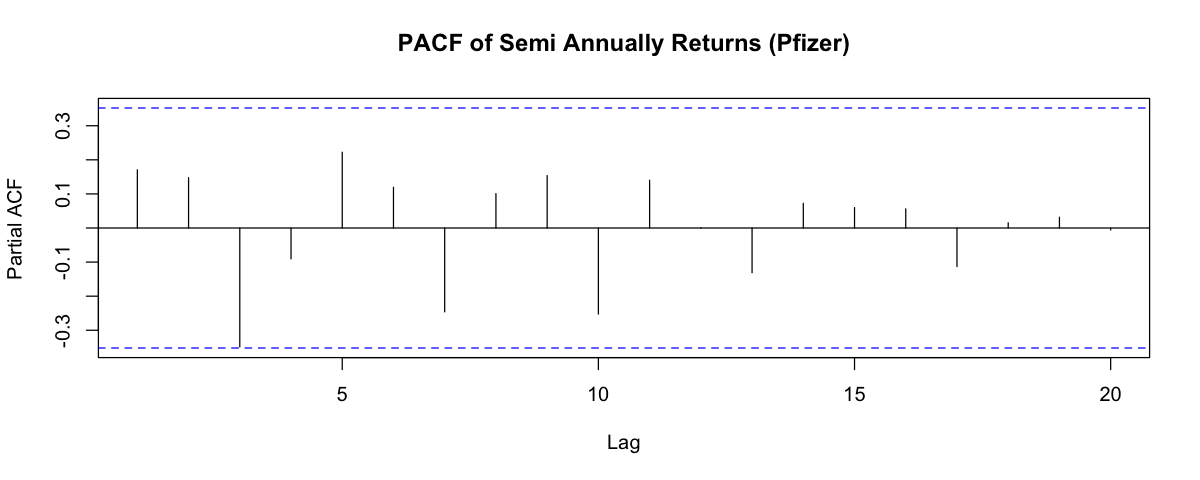

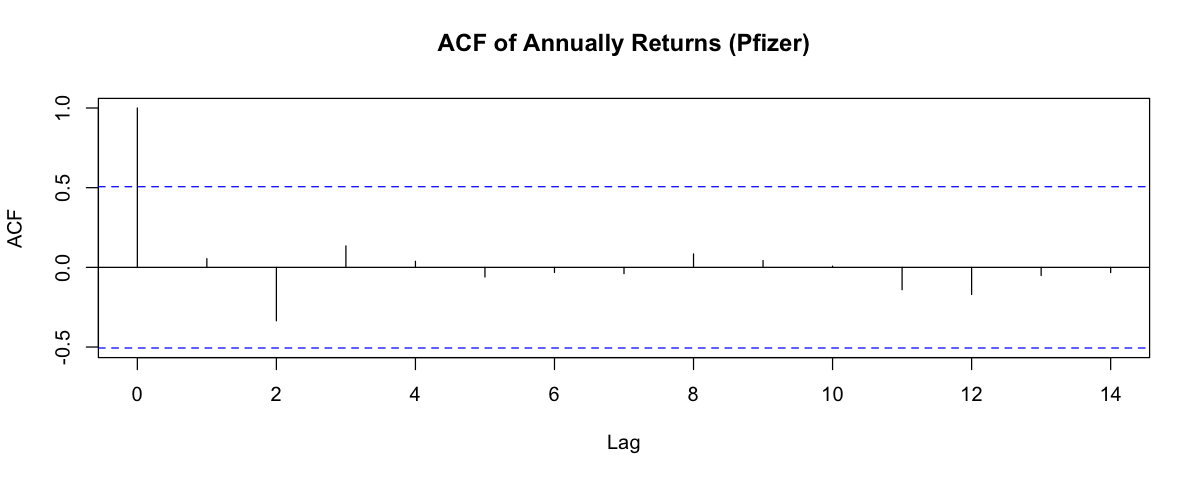

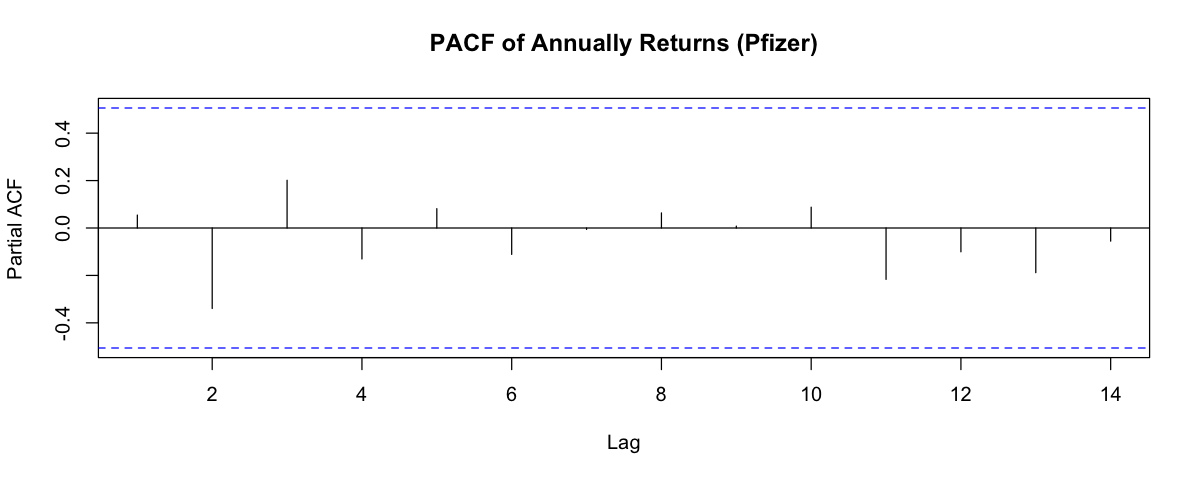

In [362]:
#| warning: false
#| results: hide

# Create a list of periods we want to look at
periods <- list(
    weekly = "week",
    monthly = "month", 
    semi_annually = "6 months",
    annually = "year"
)

# Loop through each time period
for (period_name in names(periods)) {
    cat("Processing:", toupper(period_name), "\n")
    
    # Create proper period returns (one observation per period)
    pfe_period <- pfe %>%
        mutate(period = floor_date(datadate, periods[[period_name]])) %>%
        group_by(period) %>%
        arrange(datadate) %>%
        slice_tail(n = 1) %>%  
        ungroup() %>%
        arrange(datadate) %>%
        mutate(period_ret = (prccd / lag(prccd)) - 1) %>%
        filter(!is.na(period_ret))
    
    # View tibble (dataframe) using the following:
    # print(head(pfe_period))
    # cat("Number of periods:", nrow(pfe_period), "\n\n")
    
    # ACF of actual period returns (suppress warnings)
    suppressWarnings(
        acf(pfe_period$period_ret, lag.max = 20, 
            na.action = na.omit,
            main = paste("ACF of", 
            tools::toTitleCase(gsub("_", " ", period_name)), 
            "Returns (Pfizer)"))
    )
    
    # PACF of actual period returns (suppress warnings)
    suppressWarnings(
        pacf(pfe_period$period_ret, lag.max = 20,
             na.action = na.omit,
             main = paste("PACF of", 
             tools::toTitleCase(gsub("_", " ", period_name)), 
             "Returns (Pfizer)"))
    )
}

# Moving Average Crossover Strategy 

In [363]:
pfe <- pfe %>%
  filter(datadate >= as.Date("2020-01-01")) %>%
  arrange(datadate)

In [364]:
#| tbl-cap: "Optimal fast and slow MA lags" 
source('bs-signal.r')
source('backtest.r')

# Grids to search
fast_grid <- c(20, 30, 40, 50)
slow_grid <- c(60, 90, 120, 150)

# Store data for each combination
results <- data.frame(
  fast = integer(),
  slow = integer(),
  final_equity = numeric(),
  stringsAsFactors = FALSE
)

for (f in fast_grid) {
  for (s in slow_grid) {
    if (f >= s) next  
    
    # 1) Generate signals
    sig <- ma_signal(pfe$prccd, fast = f, slow = s)
    
    # 2) Backtest
    bt  <- backtest_ma(pfe$prccd, signal = sig)
    
    # 3) Store final equity (performance metric)
    final_eq <- tail(bt$equity, 1)
    
    results <- rbind(
      results,
      data.frame(fast = f, slow = s, final_equity = final_eq)
    )
  }
}

# Pick best-performing combination
best_idx   <- which.max(results$final_equity)
best_fast  <- results$fast[best_idx]
best_slow  <- results$slow[best_idx]
results[best_idx, ] 


,fast,slow,final_equity
,<dbl>,<dbl>,<dbl>
15,50,120,1.178767


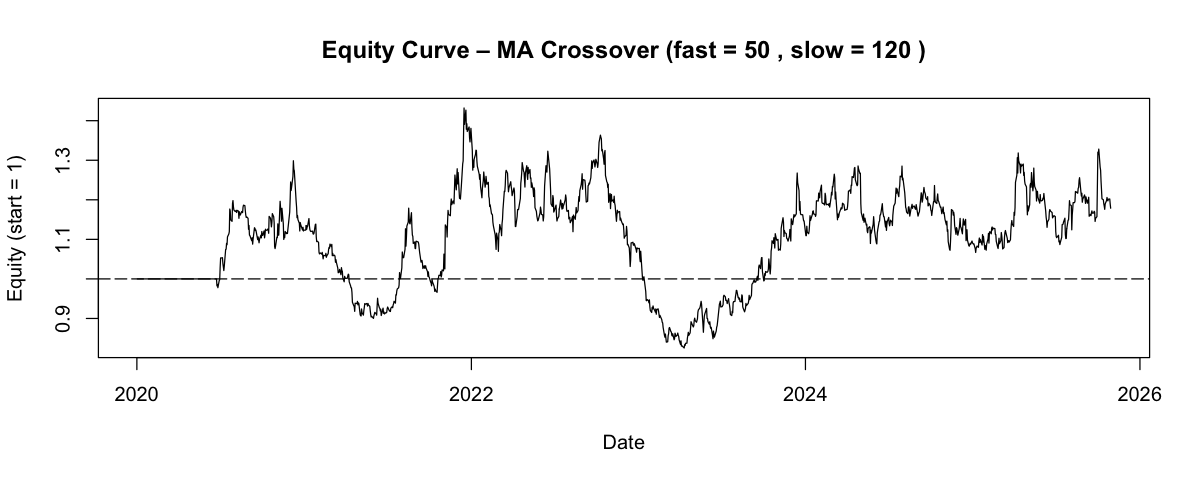

In [365]:
#| fig-cap: "Equity Curve using MA Crossover Strategy"
price <- pfe$prccd

# Generate signals and backtest using the optimal windows
best_signal <- ma_signal(price, fast = best_fast, slow = best_slow)
best_bt     <- backtest_ma(price, signal = best_signal)

# Equity curve plot
plot(
  pfe$datadate, best_bt$equity, type = "l",
  xlab = "Date", ylab = "Equity (start = 1)",
  main = paste("Equity Curve – MA Crossover (fast =", best_fast,
               ", slow =", best_slow, ")")
)
abline(h = 1, lty = 5)  


## Performance Summary of Moving Average Strategy

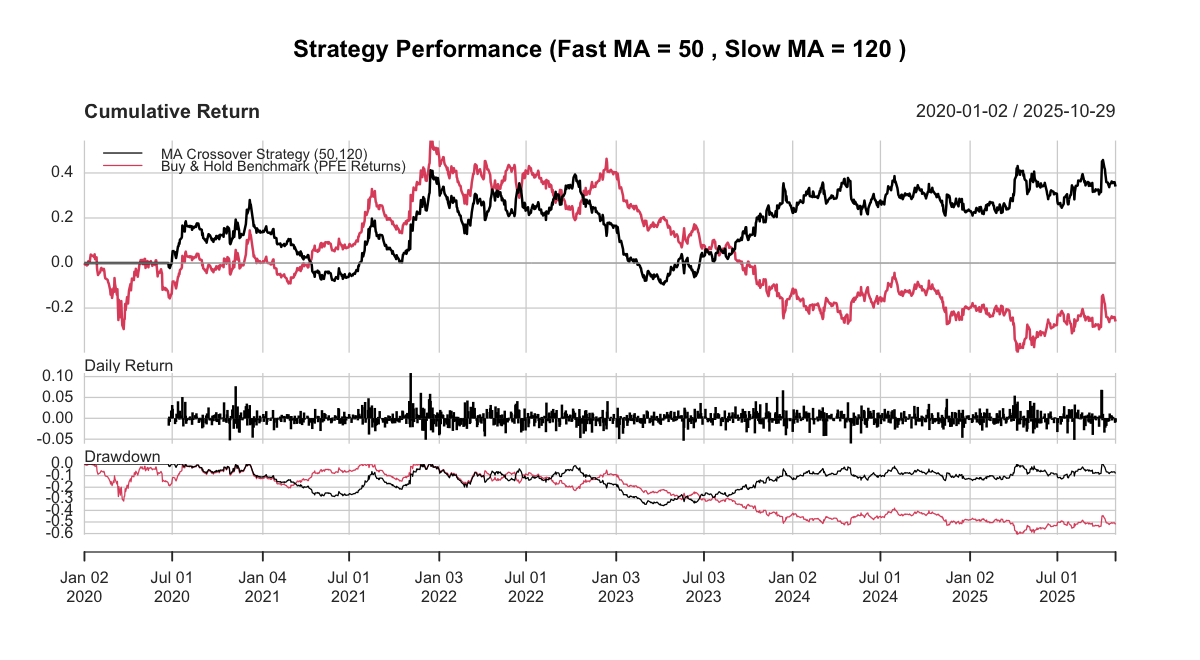

In [366]:
#| fig-cap: "Optiaml MA Crossover Performance Summary"
# Store data in an xts readable dataframe
strategy_returns <- xts(best_bt$returns, order.by = pfe$datadate)
benchmark_returns <- xts(pfe$ret, order.by = pfe$datadate)

comparison <- merge(strategy_returns, benchmark_returns)
colnames(comparison) <- c("MA Crossover Strategy (50,120)", 
                    "Buy & Hold Benchmark (PFE Returns)")

# Performance Summary Chart
options(repr.plot.width = 10, repr.plot.height = 5.5) 
charts.PerformanceSummary(
    comparison, 
    geometric = FALSE,
    main = paste("Strategy Performance (Fast MA =", 
        best_fast, ", Slow MA =", best_slow, ")")
)

# Reset to default height
options(repr.plot.width = 10, repr.plot.height = 4)

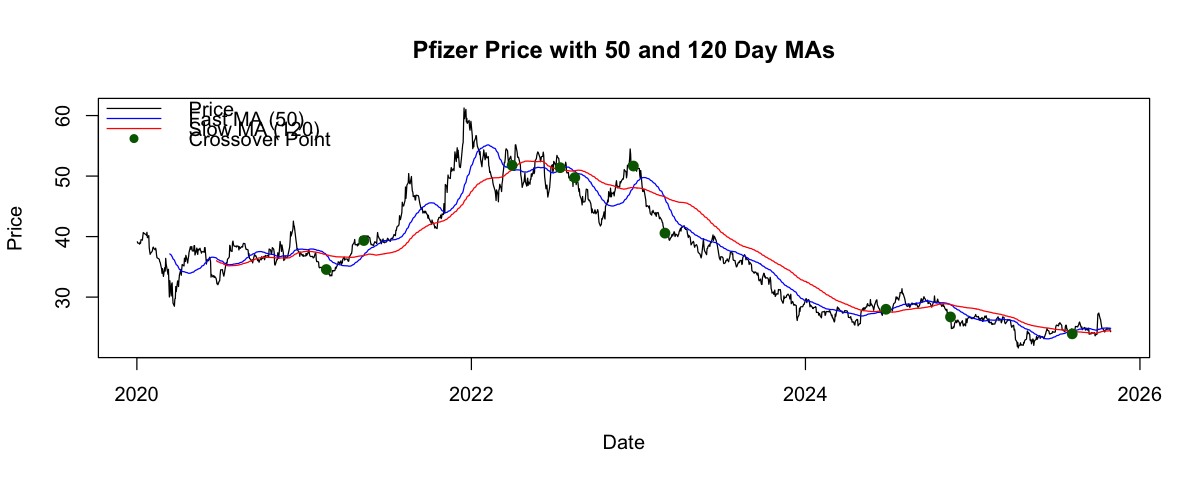

In [367]:
#| fig-cap: "Pfizer Price with 50 and 120 Day MAs"
# Compute moving averages for the best windows
fast_ma_best <- moving_avg(price, win_size = best_fast)
slow_ma_best <- moving_avg(price, win_size = best_slow)

# Base plot: price
plot(
  pfe$datadate, price, type = "l",
  xlab = "Date", ylab = "Price",
  main = paste("Pfizer Price with", best_fast, 
  "and", best_slow, "Day MAs")
)

# Add moving averages
lines(pfe$datadate, fast_ma_best, col = "blue")
lines(pfe$datadate, slow_ma_best, col = "red")

# Identify crossover points
spread    <- fast_ma_best - slow_ma_best
cross_idx <- which(diff(sign(spread)) != 0) + 1  

# Add crossover markers to the plot
points(
  pfe$datadate[cross_idx],    
  price[cross_idx],           
  pch = 16, col = "darkgreen", cex = 1.2
)

legend(
  "topleft",
  legend = c(
    "Price",
    paste0("Fast MA (", best_fast, ")"),
    paste0("Slow MA (", best_slow, ")"),
    "Crossover Point"
  ),
  col = c("black", "blue", "red", "darkgreen"),
  lty = c(1, 1, 1, NA),  
  pch = c(NA, NA, NA, 16),  
  bty = "n"
)

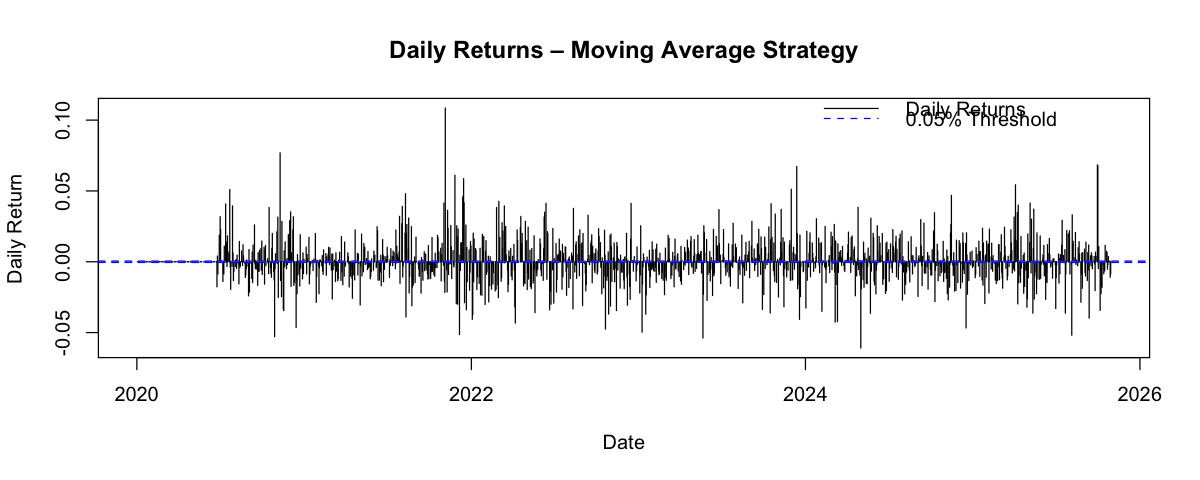

In [368]:
#| fig-cap: "Moving Average Daily Returns Plot"
# Correct level for ±0.05% daily return
threshold <- 0.0005 

plot(
  pfe$datadate, strategy_returns, 
  type = "h",
  xlab = "Date",
  ylab = "Daily Return",
  main = "Daily Returns – Moving Average Strategy"
)

# Zero line
abline(h = 0, lty = 2, col = "gray")

# ±0.05% marker lines
abline(h = threshold,  lty = 2, col = "blue")
abline(h = -threshold, lty = 2, col = "blue")

legend(
  "topright",
  legend = c("Daily Returns", "0.05% Threshold"),
  col = c("black", "blue"),
  lty = c(1, 2),
  bty = "n"
)

# Bollinger Bands Trading Strategy (Created with GenAI)

We will also document the performance of another strategy, the Bollinger Bands Strategy. We utilise generative-AI to develop a function which replicates the Bollinger Bands Strategy. The fundamental approach of this strategy is to plot the SMA, an upper and lower band (+/- 2 standard deviatinons away from SMA) and observe whether there is volatility and potentialy overbuying/overselling conditions that we can arbitrage from. We see that the function the LLM develops, is to indicate whether we should hold a long or short position, depending on the movement of prices. The function tells us that we should take a long position if prices go above the upper band and a short position if prices go below the lower band.<br><br>

The prompt we provided to the LLM was: <br>

Write clean, well-commented R code to implement a Bollinger Bands breakout trading strategy. Assume the dataset `pfe` contains `datadate` (Date) and `prccd` (closing price).

The script must:

1. Define a function to compute Bollinger Bands (middle, upper, lower) using parameters `n` and `k`.
2. Create a function to generate trading signals (+1 long, −1 short, 0 neutral) based on Bollinger breakout logic.
3. Include a backtesting function that computes daily strategy returns and an equity curve, using lagged signals to prevent lookahead bias.
4. Compare the strategy to a buy-and-hold benchmark and produce an interpretable performance summary including an equity curve plot.
5. Ensure code is readable, well-structured, and appropriate for use in a technical report.

In [369]:
# Setting up Bollinger Bands
bollinger_bands <- function(prices, n = 20, k = 2) {
  N   <- length(prices)
  mid <- rep(NA_real_, N)
  sdv <- rep(NA_real_, N)

  if (n > N) {
    warning("Window size n is larger than length of price series.")
    return(list(
      middle = mid,
      upper  = rep(NA_real_, N),
      lower  = rep(NA_real_, N)
    ))
  }

  for (i in n:N) {
    window_vals <- prices[(i - n + 1):i]
    mid[i] <- mean(window_vals, na.rm = TRUE)
    sdv[i] <- stats::sd(window_vals, na.rm = TRUE)
  }

  upper <- mid + k * sdv
  lower <- mid - k * sdv

  return(list(
    middle = mid,
    upper  = upper,
    lower  = lower
  ))
}

# Bollinger Bands Indicator
bb_signal <- function(price, n = 20, k = 2) {
  bb <- bollinger_bands(price, n = n, k = k)

  upper <- bb$upper
  lower <- bb$lower

  signal <- rep(0, length(price))

  # breakout logic
  signal[price > upper] <-  1   # long when breaking above upper band
  signal[price < lower] <- -1   # short when breaking below lower band

  return(signal)
}

In [370]:
# Compute Bollinger Bands
bb    <- bollinger_bands(price, n = 20, k = 2)
mid   <- bb$middle
upper <- bb$upper
lower <- bb$lower

# Generate signals (breakout)
sig_bb <- bb_signal(price, n = 20, k = 2)

# Store Bollinger outputs in data frame
pfe$bb_mid    <- mid
pfe$bb_upper  <- upper
pfe$bb_lower  <- lower
pfe$bb_signal <- sig_bb

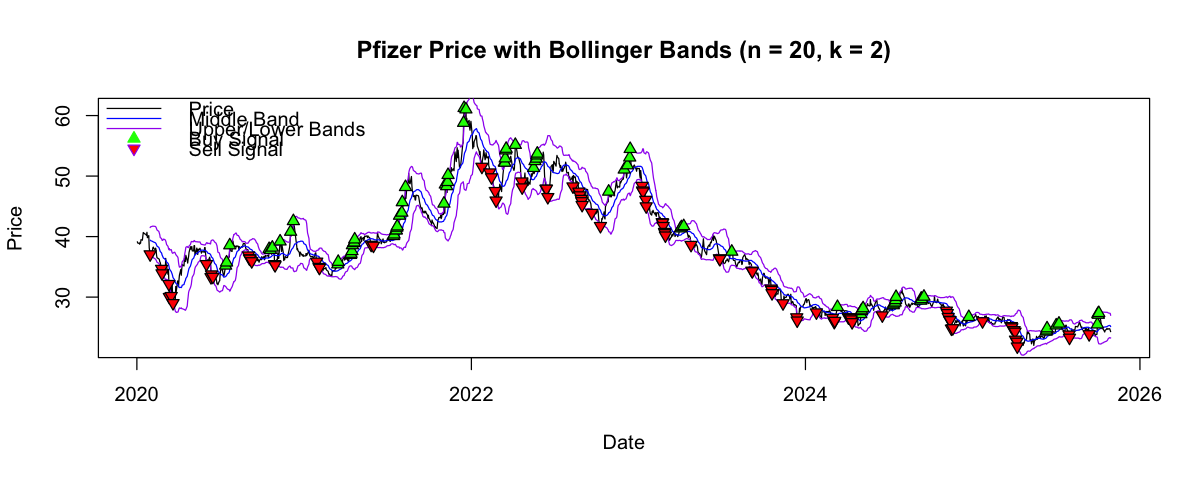

In [371]:
#| fig-cap: "Pfizer Price with Bollinger Bands"
plot(
  pfe$datadate, price, type = "l",
  xlab = "Date", ylab = "Price",
  main = "Pfizer Price with Bollinger Bands (n = 20, k = 2)"
)

# Add bands
lines(pfe$datadate, pfe$bb_mid,   col = "blue")
lines(pfe$datadate, pfe$bb_upper, col = "purple")
lines(pfe$datadate, pfe$bb_lower, col = "purple")

# Mark buy (break above upper) and sell (break below lower)
buy_idx  <- which(pfe$bb_signal ==  1)
sell_idx <- which(pfe$bb_signal == -1)

points(pfe$datadate[buy_idx],  price[buy_idx],  pch = 24, bg = "green")
points(pfe$datadate[sell_idx], price[sell_idx], pch = 25, bg = "red")

legend(
  "topleft",
  legend = c("Price", "Middle Band", "Upper/Lower Bands", 
                "Buy Signal", "Sell Signal"),
  col    = c("black", "blue", "purple", "green", "purple"),
  lty    = c(1, 1, 1, NA, NA),
  pch    = c(NA, NA, NA, 24, 25),
  pt.bg  = c(NA, NA, NA, "green", "red"),
  bty    = "n"
)

## Bollinger Band Trading Strategy Evaluation

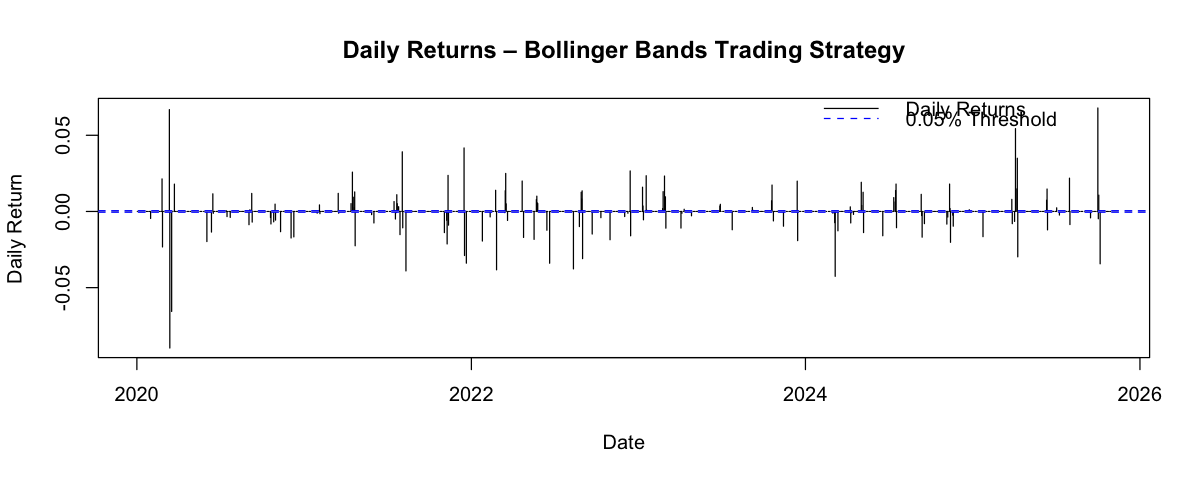

In [372]:
#| fig-cap: "Bollinger Bands Daily Returns Plot"
# Daily returns from the Bollinger Bands strategy
strategy_returns_bb <- bt_bb$returns

plot(
  pfe$datadate, strategy_returns_bb, 
  type = "h",
  xlab = "Date",
  ylab = "Daily Return",
  main = "Daily Returns – Bollinger Bands Trading Strategy"
)

# Zero line
abline(h = 0, lty = 2, col = "gray")

# ±0.05% marker lines
abline(h = threshold,  lty = 2, col = "blue")
abline(h = -threshold, lty = 2, col = "blue")

legend(
  "topright",
  legend = c("Daily Returns", "0.05% Threshold"),
  col = c("black", "blue"),
  lty = c(1, 2),
  bty = "n"
)


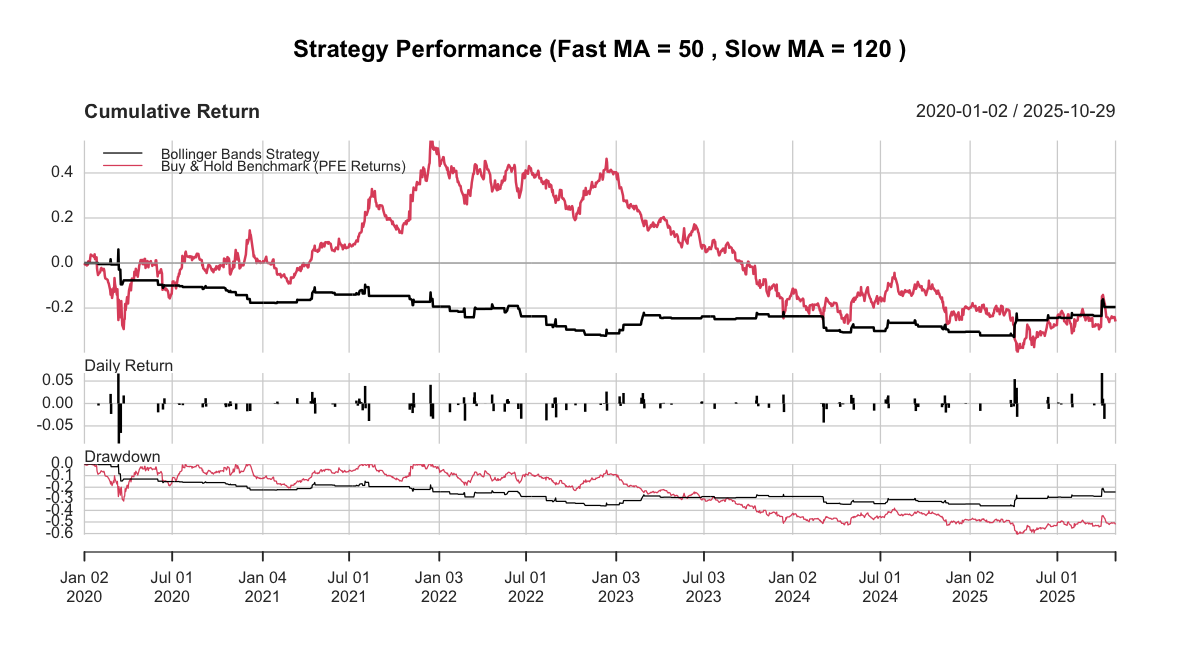

In [373]:
#| fig-cap: "Bollinger Bands Performance Summary"
bollinger_returns <- xts(
  bt_bb$returns,
  order.by = pfe$datadate   # or pfe_2020$datadate if you're using the subset
)

comparison2 <- merge(bollinger_returns, benchmark_returns, all = FALSE)
colnames(comparison2) <- c("Bollinger Bands Strategy", 
                           "Buy & Hold Benchmark (PFE Returns)")

# Performance Summary Chart
options(repr.plot.width = 10, repr.plot.height = 5.5) 
charts.PerformanceSummary(
    comparison2, 
    geometric = FALSE,
    main = paste("Strategy Performance (Fast MA =", 
        best_fast, ", Slow MA =", best_slow, ")")
)

# Analysis of Findings

From the autocorrelation analysis across multiple time horizons (daily, weekly, monthly, semi-annual, and annual returns), we observe that the majority of autocorrelation coefficients lie within the statistical confidence bounds. Even at longer aggregation intervals, no lag shows a magnitude greater than 0.2 that is also statistically significant. This suggests there is no meaningful autocorrelation structure present in Pfizer’s return series over the examined period.<br><br>

In practical terms, this means the return behaviour resembles white noise, where past returns do not help predict future returns. While this property is desirable for time series forecasting models—since it reduces the risk of overfitting—it also implies that returns do not exhibit persistent momentum, mean reversion, or cyclical patterns that could be systematically exploited. Therefore, based on the ACF and PACF diagnostics, there is limited evidence of predictable behaviour in Pfizer’s historical returns. This makes it challenging to extract profitable signals solely from autocorrelation-based timing or statistical arbitrage approaches. <br><br>

Looking at our moving average cross-over strategy, we see a clear improvement over a passive buy-and-hold strategy, as shown in Figure 2. In particular, we can see the strategy performs well during negative periods, where we see the returns of the MA strategy converging away from the holding strategy. Also, the drawdown panel indicates that the strategy mitigates downside risk more effectively than buy-and-hold, remaining shallower and recovering faster during market downturns. This behaviour is consistent with the nature of moving-average-based models, which reduce exposure during declining markets by switching to neutral or short positions once the fast moving average crosses below the slow moving average. <br><br>

Figure 3 visualises these crossover points, which represent the entry and exit signals underpinning the strategy. The relatively low frequency of trades suggests that the model avoids excessive transaction noise and relies primarily on structural price trends rather than short-term volatility. However, the flat and volatile return periods also indicate that the strategy is less effective in sideways markets, where false crossovers can occur. Overall, the crossover system captures meaningful directional price movement while controlling drawdowns, resulting in superior cumulative returns relative to buy-and-hold over the evaluated period. <br><br>

Looking at the bollinger bands strategy, we see that it takes a different approach and we see that returns are not generated as aggressively compared to the moving average strategy. We can see that the strategy takes a more passive approach from looking at the daily return plot on Figure 7 - we see that there are breaks in the daily return, this suggests that the strategy doens't execute everyday and will perform intraday executions if price hits a certain band. However, a benefit to using this strategy is that it smooths out drawdowns and we see that they don't dip as low as a simple hold. <br><br>

Therefore, looking at the strategy overall, we believe that it is effective - despite returns not being as high as the cross moving average strategy, it still provides much higher daily returns compared to what we would typically see on a day-to-day (~ +/-0.05%). However, the Bollinger Bands may not have performed so well in this backtest for PFE because it performs more optimally if the asset's price converges to a certain price (i.e. the asset is mean reverting); the more stationary the price dynamics, the more reliable Bollinger Bands become, which is not what we see here. Instead, we see strong upward and downward trends, leading to the bands tend misidentifying continuation signals, hence causing worse performance.
